In [1]:
import sys
import re
import numpy as np
import pandas as pd
from pprint import pprint
import requests
from bs4 import BeautifulSoup

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

# Import and Combine Review Dataframes

In [2]:
import pickle

In [3]:
endomondo_df = pd.read_pickle("./endomondo_reviews_df.pkl")
google_fit_df = pd.read_pickle('./googlefit_reviews_df.pkl')
strava_df = pd.read_pickle('./strava_df_reviews_df.pkl')
under_armor_df = pd.read_pickle('./under_armor_df_reviews_df.pkl')
workout_trainer_df = pd.read_pickle('./workout_trainer_reviews_df.pkl')

In [5]:
len(endomondo_df)+len(google_fit_df)+len(strava_df)

37520

In [9]:
review_df = pd.concat([endomondo_df,google_fit_df,strava_df, under_armor_df, workout_trainer_df])
print('You have colleceted', len(review_df), 'reviews')

You have colleceted 53703 reviews


In [13]:
five_star_reviews = review_df[review_df['stars']==5]
five_star_reviews = five_star_reviews.reset_index()
five_star_reviews['index'] = five_star_reviews.index
five_star_reviews.head()

,index,reviews,stars
0,0,All I wanted was something to display my curre...,5
1,1,"Great app, recent updates made it much better ...",5
2,2,I have only used Endomondo to track my runs. f...,5
3,3,Absolutely LOVE this app. Use it primarily for...,5
4,4,Love Endomondo on the phone - can't fault it! ...,5


In [34]:
bad_reviews = review_df[review_df['stars'] < 4]
bad_reviews = bad_reviews.reset_index()
bad_reviews['index'] = bad_reviews.index
bad_reviews.head()

,index,reviews,stars
0,0,I've been using this app for about 6 years now...,3
1,1,Most of app won't work without internet or pre...,2
2,2,I have been having a couple issues. More than ...,3
3,3,Overall the app is works as advertised and int...,3
4,4,I want to use this app to measure the distance...,2


In [35]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [36]:
processed_docs = bad_reviews['reviews'].map(preprocess)
processed_docs[:10]

0    [year, fine, problem, address, lose, signal, l...
1    [work, internet, premium, loos, sure, lack, si...
2    [have, coupl, issu, workout, stop, endomondo, ...
3    [overal, work, advertis, integr, garmin, conne...
4    [want, measur, distanc, calori, burn, measur, ...
5    [progress, wors, month, akway, niggl, appal, w...
6    [better, armor, take, want, push, premium, pol...
7    [frustrat, featur, free, version, abl, sort, g...
8    [question, review, basic, enjoy, endomondo, re...
9    [great, suck, go, best, run, appa, gpod, fit, ...
Name: reviews, dtype: object

In [37]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 address
1 altern
2 better
3 durat
4 endomondo
5 fine
6 give
7 know
8 list
9 long
10 lose


In [38]:
len(dictionary)

8651

In [39]:
#Filter out tokens that appear in:
#
#less than 15 documents (absolute number) or
#more than 0.5 documents (fraction of total corpus size, not absolute number).
#after the above two steps, keep only the first 5000 most frequent tokens.

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=5000)

In [40]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

[(123, 1), (147, 1), (437, 1), (443, 1)]

In [41]:
bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                               dictionary[bow_doc_100[i][0]], bow_doc_100[i][1]))

Word 123 ("activ") appears 1 time.
Word 147 ("good") appears 1 time.
Word 437 ("applic") appears 1 time.
Word 443 ("health") appears 1 time.


In [24]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [84]:
len(bad_reviews)

19789

# LDA with 3 Topics

In [139]:
#Note, rerunning the LDA model gives slightly different results each time
lda_model_3tops = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=4, workers=2, random_state=40)

In [140]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_3tops, bow_corpus, dictionary)
vis

/Users/jnaviaux/anaconda3/envs/Ongo_Science_Project/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.065169  0.083686       1        1  37.163971
1     -0.131202 -0.000366       2        1  33.108799
2      0.066033 -0.083319       3        1  29.727221, topic_info=    Category         Freq     Term        Total  loglift  logprob
287  Default  2305.000000     sync  2305.000000  30.0000  30.0000
103  Default  1398.000000    heart  1398.000000  29.0000  29.0000
183  Default  1393.000000    point  1393.000000  28.0000  28.0000
56   Default  1343.000000  connect  1343.000000  27.0000  27.0000
691  Default  1419.000000   widget  1419.000000  26.0000  26.0000
214  Default  4504.000000     step  4504.000000  25.0000  25.0000
409  Default  1086.000000    minut  1086.000000  24.0000  24.0000
77   Default  1876.000000     walk  1876.000000  23.0000  23.0000
72   Default  1151.000000   calori  1151.000000  22.0000  22.0000
115  Default   706.000000     free   706.000000  21.0000  21.0000
410  Default   717.000000     ride   717.000000  20.0000  20.0000
96   Default  1158.000000      app  1158.000000  19.0000  19.0000
220  Default  3754.000000    updat  3754.000000  18.0000  18.0000
70   Default   574.000000     bike   574.000000  17.0000  17.0000
157  Default   753.000000     mile   753.000000  16.0000  16.0000
123  Default  2801.000000    activ  2801.000000  15.0000  15.0000
194  Default   843.000000  account   843.000000  14.0000  14.0000
261  Default   889.000000    crash   889.000000  13.0000  13.0000
164  Default  2345.000000   record  2345.000000  12.0000  12.0000
403  Default  2305.000000    googl  2305.000000  11.0000  11.0000
75   Default   494.000000      rid   494.000000  10.0000  10.0000
37   Default  1428.000000    count  1428.000000   9.0000   9.0000
71   Default   555.000000     burn   555.000000   8.0000   8.0000
31   Default  2266.000000  workout  2266.000000   7.0000   7.0000
39   Default  1307.000000  distanc  1307.000000   6.0000   6.0000
30   Default  1667.000000  version  1667.000000   5.0000   5.0000
443  Default   991.000000   health   991.000000   4.0000   4.0000
101  Default   960.000000      fit   960.000000   3.0000   3.0000
109  Default   526.000000     rate   526.000000   2.0000   2.0000
80   Default  1906.000000     data  1906.000000   1.0000   1.0000
..       ...          ...      ...          ...      ...      ...
436   Topic3   146.107529    drive   176.988281   1.0214  -6.0613
238   Topic3    66.505760     hike    76.451836   1.0737  -6.8484
77    Topic3  1201.546265     walk  1876.814941   0.7671  -3.9543
191   Topic3   301.345306   regist   413.109314   0.8977  -5.3374
85    Topic3   347.901245     hour   489.147430   0.8724  -5.1938
175   Topic3   315.902710     cycl   489.239838   0.7757  -5.2902
156   Topic3   215.491470     half   313.827820   0.8372  -5.6728
164   Topic3  1127.654053   record  2345.931641   0.4806  -4.0178
90    Topic3   257.700745     rout   394.982300   0.7861  -5.4939
91    Topic3  1737.737671    track  4234.770508   0.3224  -3.5853
123   Topic3  1229.780029    activ  2801.925293   0.3896  -3.9311
224   Topic3   508.533844    accur   935.122986   0.6040  -4.8141
468   Topic3   241.597488   pretti   378.231567   0.7649  -5.5584
192   Topic3   539.646362      say  1089.215942   0.5108  -4.7548
76    Topic3   419.279785     take   784.951355   0.5860  -5.0071
324   Topic3   264.705048  tracker   434.991943   0.7164  -5.4671
104   Topic3   880.938904     like  2419.386719   0.2028  -4.2647
388   Topic3   310.204620   option   578.584778   0.5898  -5.3084
296   Topic3   420.549011  useless   967.230042   0.3802  -5.0041
403   Topic3   678.643005    googl  2305.509521  -0.0099  -4.5256
18    Topic3   941.981995     work  4074.065430  -0.2513  -4.1977
42    Topic3   438.604675    great  1197.323975   0.2089  -4.9621
148   Topic3   412.088379    start  1120.602173   0.2127  -5.0244
214   Topic3   754.448364     step  4504.455566  -0.5737 

## Make Pie Chart of 3 Top Complaint Categories

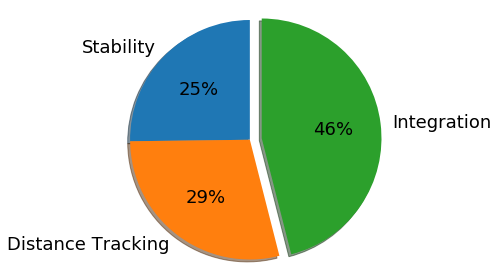

In [125]:
import matplotlib.pyplot as plt

# Pie chart
labels = ['Stability','Distance Tracking','Integration']
sizes = [4987, 5693,9109]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0,0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 18})
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
fig1.savefig('Complaints_from_other_apps_LDA.png',bbox_inches='tight');

## Ongo General Pie Chart

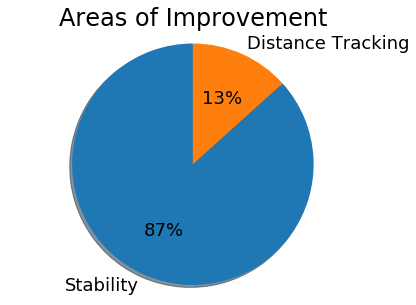

In [131]:
# Pie chart
labels = ['Stability','Distance Tracking']
sizes = [26, 4]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0,0)  
fig1, ax1 = plt.subplots();
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90,textprops={'fontsize': 18})
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Areas of Improvement', fontsize = 24)
plt.show();

fig1.savefig('Complaints_from_Ongo.png',bbox_inches='tight');

# Compute coherence vs. number of topics

In [147]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_3tops, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.196802520201974

Coherence Score:  0.45550876218872016


In [200]:
#Build several LDA models and calculate coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    number_of_topics = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=4, workers=2, random_state=40)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        number_of_topics.append(num_topics)

    return model_list, coherence_values, number_of_topics

In [208]:
model_list, coherence_values, number_of_topics = compute_coherence_values(dictionary, bow_corpus, processed_docs, 16)

In [209]:
number_of_topics

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [210]:
coherence_values

[0.3319401273213227,
 0.4072550316407306,
 0.44641046424253233,
 0.467217813788132,
 0.4862722974508246,
 0.4819694919608896,
 0.517385485893665,
 0.5212107657354645,
 0.5328023659772572,
 0.5371361257897473,
 0.549293745239699,
 0.5315330340816043,
 0.5234324475221004,
 0.5253223793546152,
 0.5139270629399438]

In [211]:
coherence_dict = {'Number of Topics': number_of_topics,'Coherence':coherence_values}
coherence_df = pd.DataFrame(data=coherence_dict)




In [212]:
sns.set_context('paper', font_scale=2)


#plt.ylim(0.3,.7)
#plt.xlim(0,18)

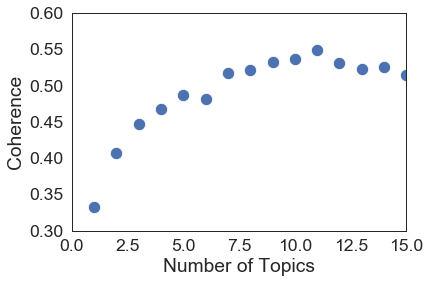

In [259]:
sns.set_style("white")
ax = sns.scatterplot(x='Number of Topics', y='Coherence', s=150, data=coherence_df);
plt.xlim(0,15)
plt.ylim(0.3,0.6)
ax.patch.set_alpha(0)

In [240]:
gradient = []
for i in range(0,len(coherence_df['Coherence'])):
    if i == 0:
        gradient.append(0)
    else:
        gradient.append(coherence_df['Coherence'][i]-coherence_df['Coherence'][i-1])

coherence_df['Change in Coherence'] = gradient
coherence_df.head()


,Number of Topics,Coherence,Change in Coherence
0,1,0.331940,0.000000
1,2,0.407255,0.075315
2,3,0.446410,0.039155
3,4,0.467218,0.020807
4,5,0.486272,0.019054


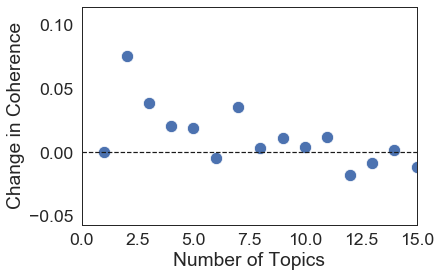

In [252]:
ax = sns.scatterplot(x='Number of Topics', y='Change in Coherence', s=150,data=coherence_df)
plt.hlines([0], 0,15,linestyle = 'dashed')
plt.xlim(0,15);
